In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import gymnasium as gym
from transformers import AutoImageProcessor

In [10]:
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker


from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.modeling.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor
from uav_active_sensing.config import DEVICE
from uav_active_sensing.plots import visualize_tensor

In [9]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)  # TODO: Download this in advance
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")  # TODO: Download this in advance
reward_function = RewardFunction(mae_model)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization


### Test random movement

In [11]:
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function, seed=45)
env = ImageExplorationEnv(env_config)

In [15]:
env_checker.check_env(env)

(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)


In [22]:
# Test starting position dist
mean_h = 0
mean_w = 0


n = 100_000
for i in range (n):
  env.reset()
  h, w = env._sensor_pos[0].cpu().numpy()
  norm_h = (h - (env.img_height//2)) / (env.img_height//2)
  norm_w = (w - (env.img_width//2)) / (env.img_width//2)

  mean_h += norm_h
  mean_w += norm_w

mean_h = mean_h / n
mean_w = mean_w / n

print(mean_h, mean_w)

-0.07598267857143018 -0.07353455357143018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.6225708].


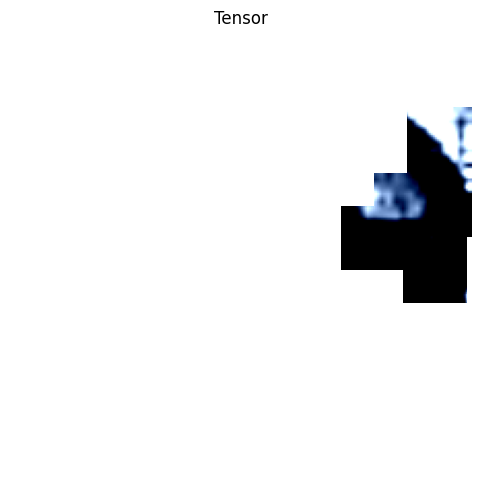

In [21]:

env.reset()
for j in range(50):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)

for k in range(env.batch_size):
    visualize_tensor(env.sampled_img[k])



### Test kernel size increase

In [ ]:
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

In [8]:

env.reset()

for i in range(env.img_height // env.sensor_height // 2 - 1):
    sample_action = np.array([[0, 0, 1] for i in range(env.batch_size)])
    env.step(sample_action)
    # env._sensor_pos = env.sensor_max_pos_from_kernel_size
    # print(env._kernel_size)
    # print(env.sensor_max_pos_from_kernel_size)
    # print(env.fov_bbox)

for k in range(env.batch_size):
    visualize_tensor(env.img[k])
    visualize_tensor(env.sampled_img[k])


### Test deterministic behaviour for a given seed-

In [33]:
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)
env.reset()
first_run_actions = []
for j in range(5):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)
    first_run_actions.append(sample_action)

first_run = env.sampled_img.detach().clone()

env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)
second_run_actions = []
env.reset()
for j in range(5):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)
    second_run_actions.append(sample_action)

second_run = env.sampled_img.detach().clone()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.4831374].


True
True
True
True
True


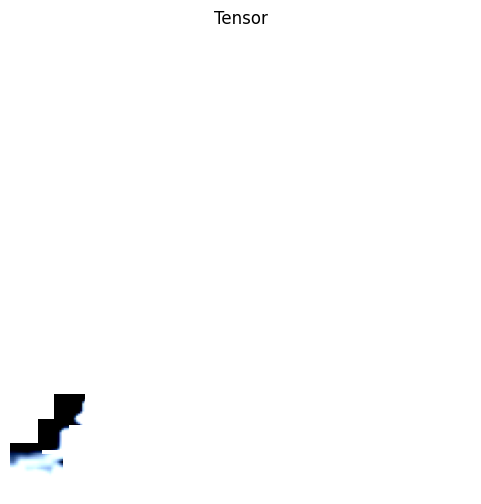

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.4831374].


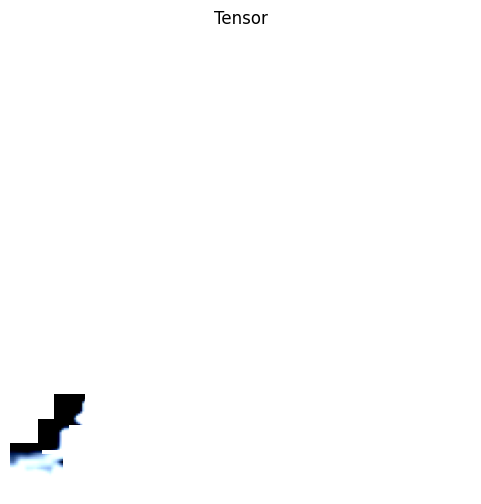

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7732207].


--------------------------------------------------


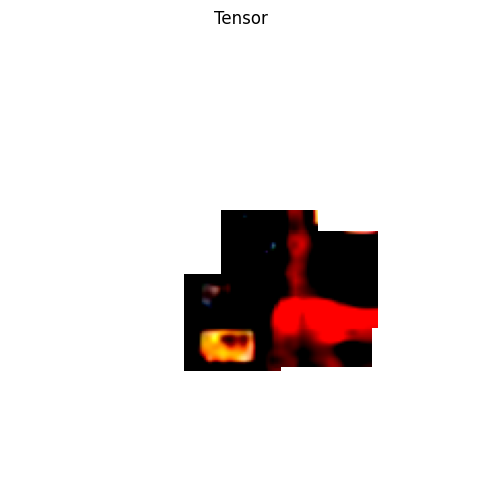

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7732207].


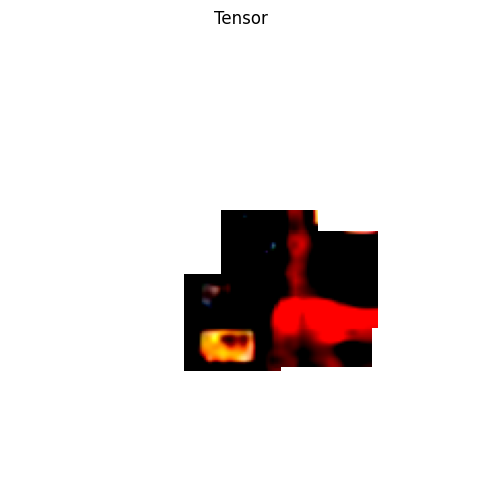

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4935164].


--------------------------------------------------


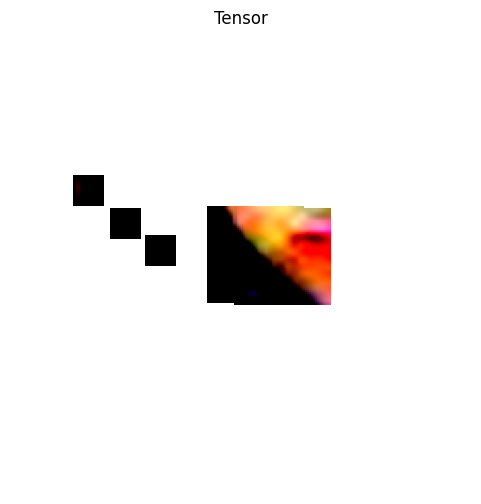

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4935164].


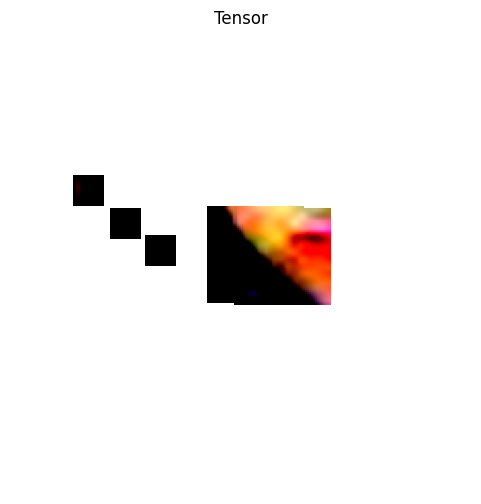

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7947614..2.6051416].


--------------------------------------------------


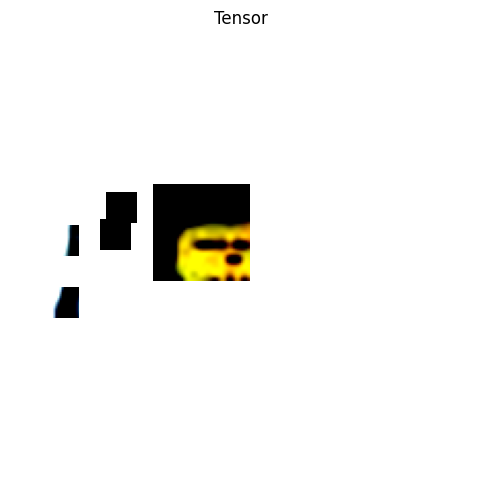

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7947614..2.6051416].


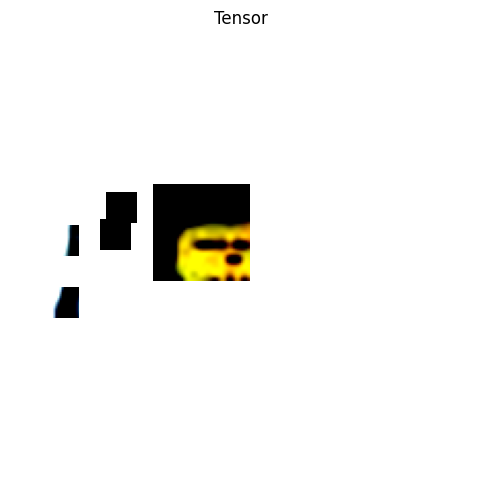

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1410893].


--------------------------------------------------


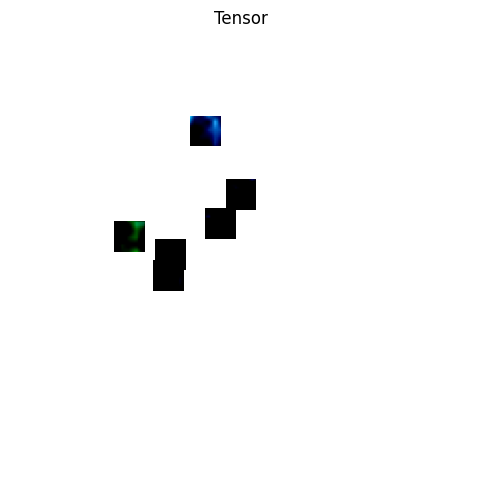

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1410893].


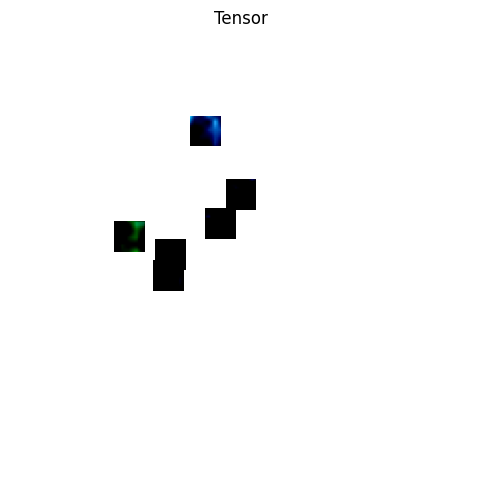

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


--------------------------------------------------


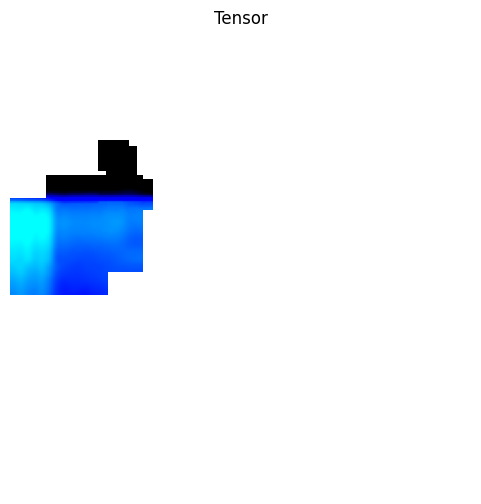

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


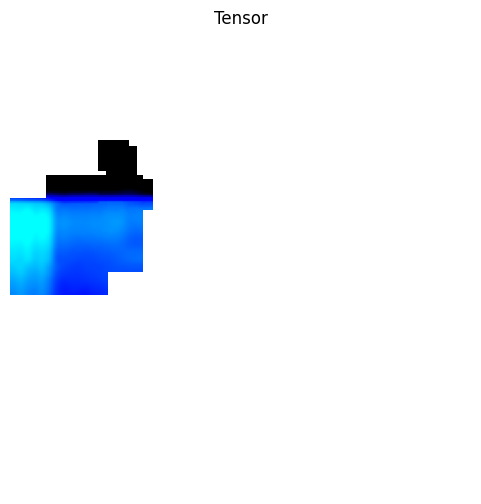

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.9079739].


--------------------------------------------------


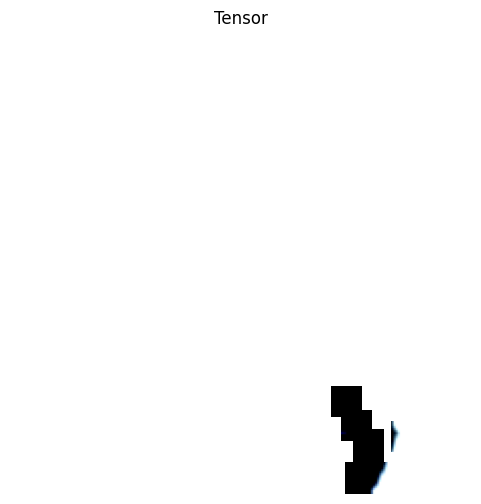

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.9079739].


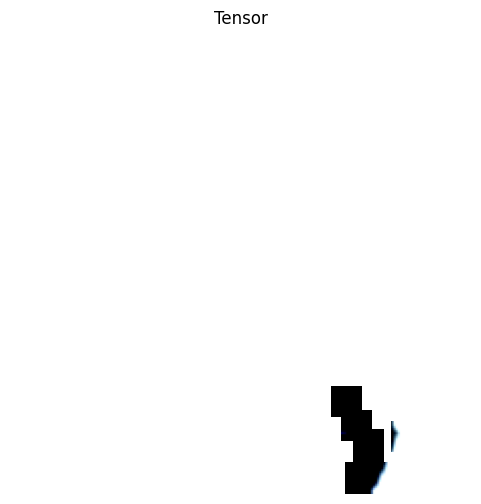

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


--------------------------------------------------


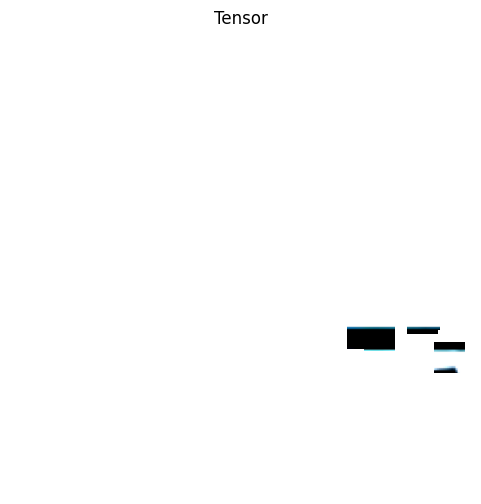

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


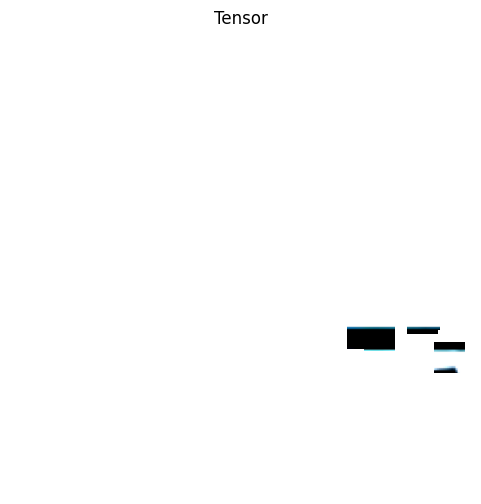

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96590656..2.576093].


--------------------------------------------------


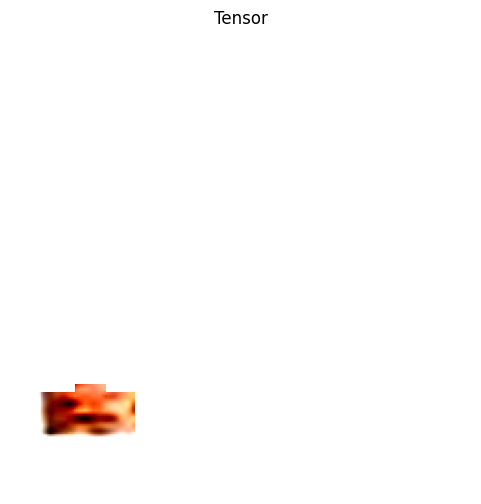

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96590656..2.576093].


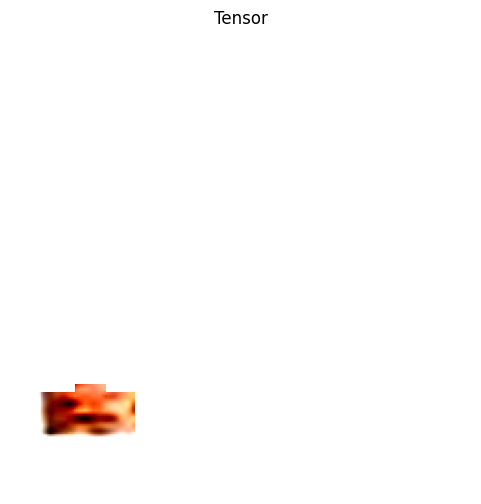

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..1.9602615].


--------------------------------------------------


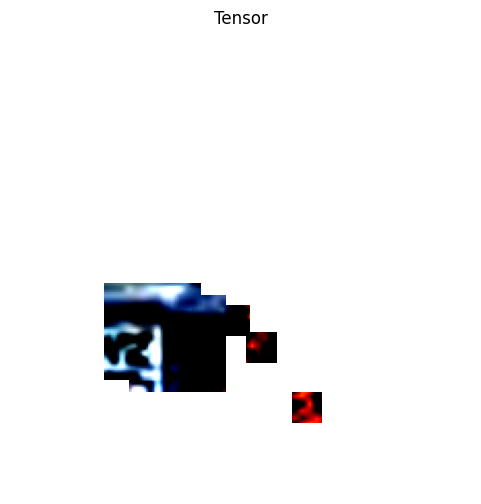

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..1.9602615].


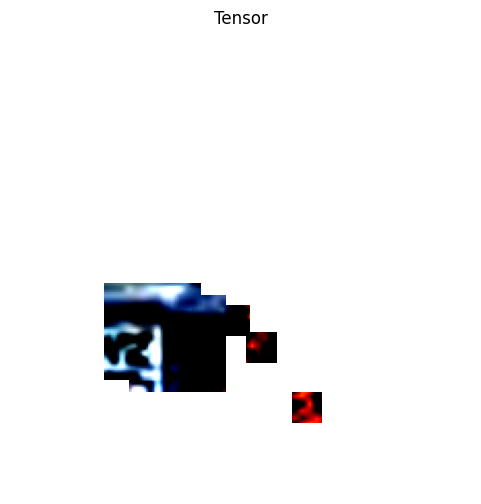

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].


--------------------------------------------------


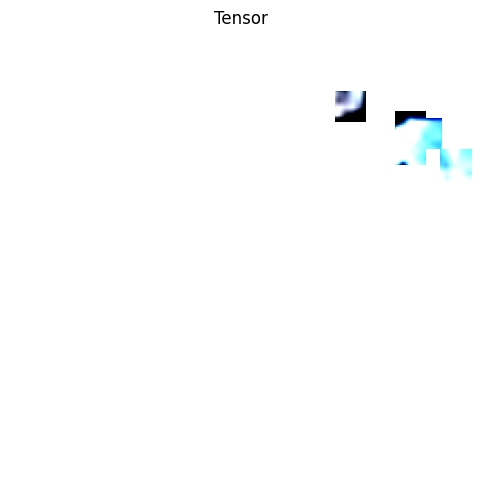

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].


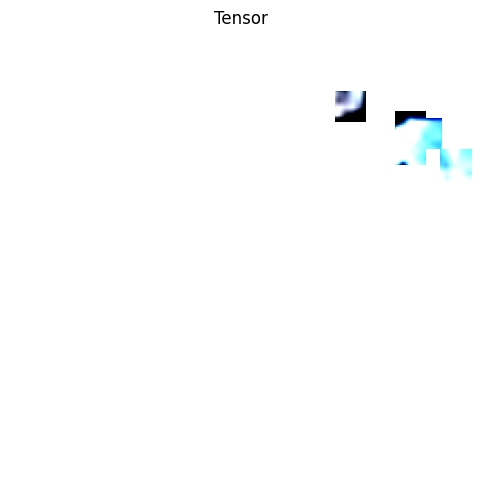

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9675868..0.65630615].


--------------------------------------------------


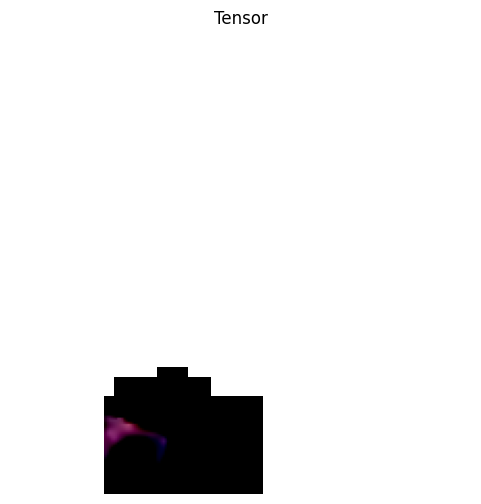

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9675868..0.65630615].


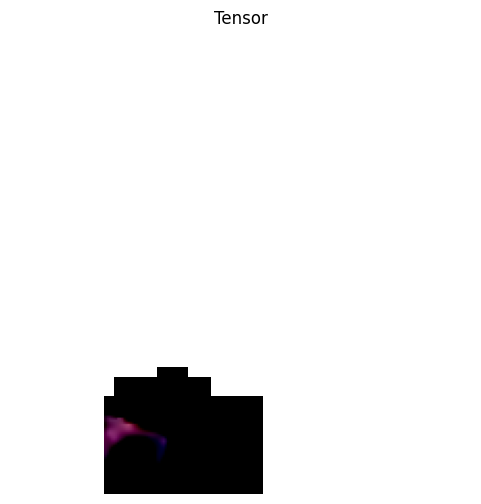

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67942464..0.53106755].


--------------------------------------------------


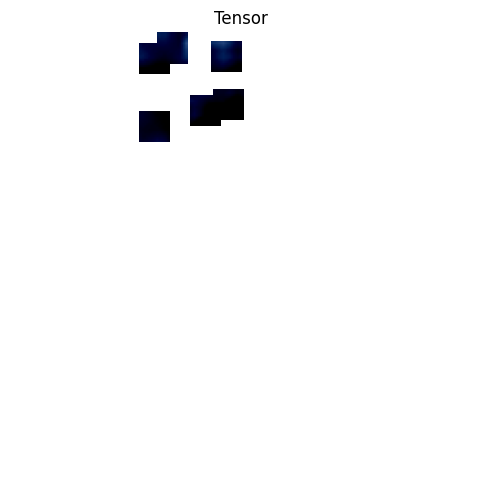

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67942464..0.53106755].


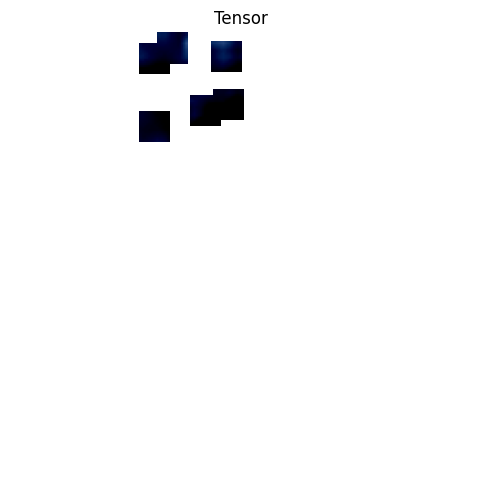

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1604552].


--------------------------------------------------


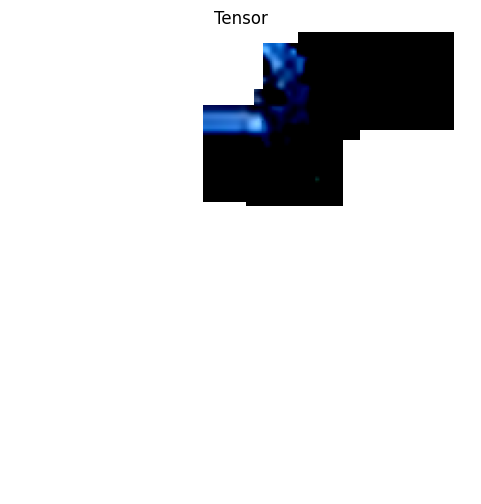

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1604552].


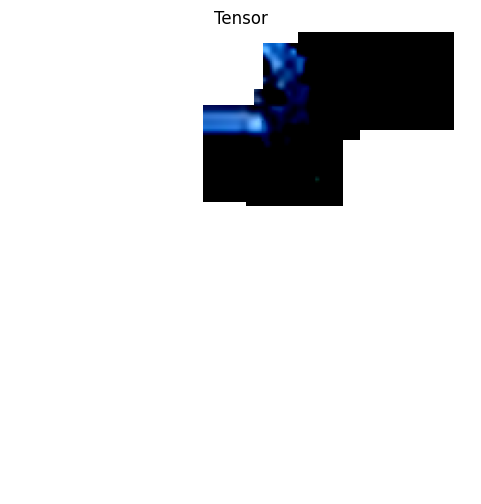

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0741408..2.4134207].


--------------------------------------------------


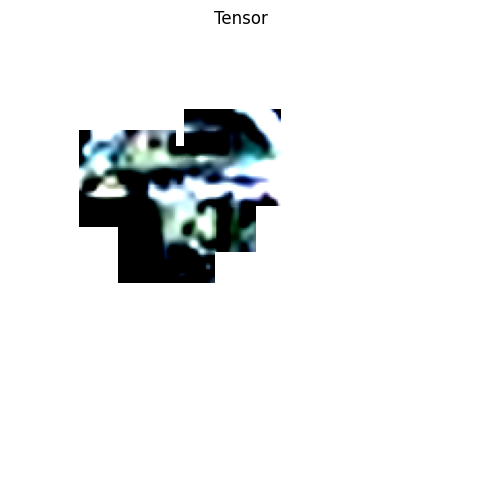

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0741408..2.4134207].


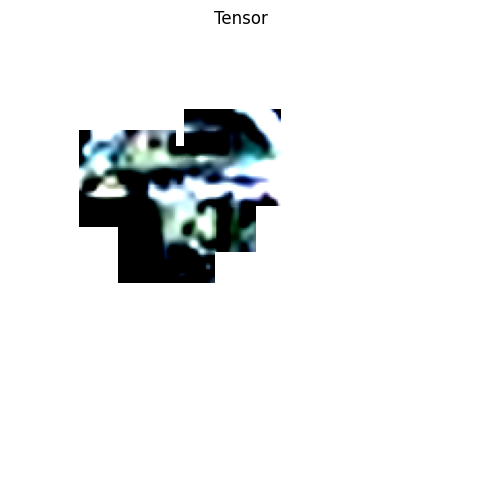

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481791..0.6953781].


--------------------------------------------------


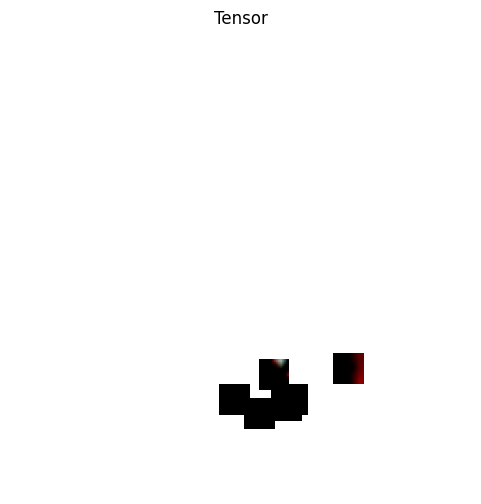

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481791..0.6953781].


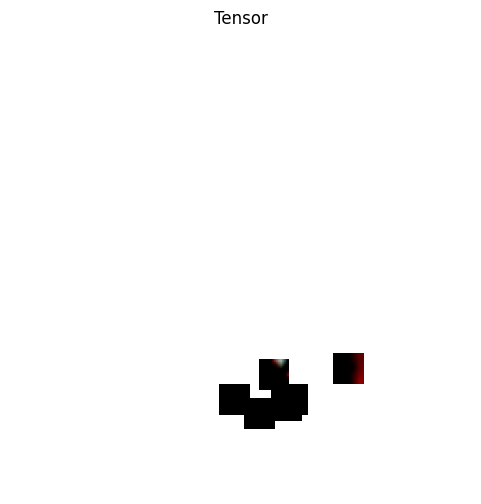

--------------------------------------------------


In [34]:
# Images shoud be identical if the sampling is deterministic (fixed seed)

for j in range(5):
    print((first_run_actions[j] == second_run_actions[j]).all())

for k in range(env.batch_size):
    visualize_tensor(first_run[k])
    visualize_tensor(second_run[k])
    print("-" * 50)
